<a href="https://colab.research.google.com/github/KevKibe/Genome-Data-Clustering/blob/main/Genome_Data_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background
DNA can be represented as a text sequence, with an alphabet that only has four letters - A (Adenosine), C (Cytosine), G (Guanine) and T (Thymine). The diversity of living organisms and their complex properties is hidden in their genomic sequences. One of the most exciting problems in modern science is to understand the organization of living matter by reading genomic sequences.<br>

One distinctive message in a genomic sequence is a piece of text, called a gene. Genes can be oriented in the sequence in either the forward or backward directions. In the highest organisms (humans, for example), the notion of a gene is more complex.<br>

# Task<br>
1. To look at the file and ensure that the text uses the alphabet of four letters (A, C, G and T), and that these letters are used without spaces. 

2. To perform PCA to identify the internal structure of the data.

3. To apply Clustering techniques to the dataset.

In [ ]:
from google.colab import files
uploaded = files.upload()

# Importing Necessary Libraries

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

The file format often used for bioinformatics and genomic data is called FASTA.
It is a normally encoded file with headers separating genetic information.
We read the file and strip it of unwanted characters and store it as a string.

In [5]:
# we open the file and get an array of its lines 
with open ("ccrescentus.fa", "r") as inputFile:
    data = inputFile.readlines()

# we concatenate each line from the second (first line is a description), stripped of empty chars 
geneticCode = ''
for line in data[1:]:
    geneticCode += line.strip()

# we count the presence of each genome(a,g,t,c)
aCount = geneticCode.count('a')
gCount = geneticCode.count('g')
tCount = geneticCode.count('t')
cCount = geneticCode.count('c')


print(geneticCode[0:30])                                     #first 30 characters
print('Test: only a,g,t,c ?')                                #to test whether there is another character apart from the four
print('a=',aCount, 'g=',gCount, 't=',tCount,'c=', cCount)    #to output the character count 
print(aCount + gCount + tCount + cCount == len(geneticCode))  # to confirm the total count is equal to the entire length

gccgatagcctatgatccccggcaggcccg
Test: only a,g,t,c ?
a= 49330 g= 103441 t= 50260 c= 102069
True


# Converting the text data into numerical format
Our string has 305,100 characters. We will divide the string into fragments of size 300 checking 4 characters at a time. We will calculate the frequencies of the 4-character length words inside each fragment of 500 characters.

In [16]:
# size of the sub strings (data points)
size = 300

dataPoints = []

# we copy the entire code into a string, which will be removed of its first elements iteratively
tempString = geneticCode

# we iteratively remove a left chunk of the string and place it into our array
while len(tempString) > 0:
    dataPoints.append(tempString[0:size])
    tempString = tempString[size:]

print(dataPoints[3])

cttgaagctcttggcgtaggtggcgtaggccaggacgtcacggtccagctggtagcttgccgacaggtcgtaggtgaagttccagtcgtcgaagctgggggcgctgacctgcggggtgtagaccgccagctgggcggcgcggcgcgcgccggtgtcggtgagcagcacgggcacgccctggccgtcgatgaccttgcgctcatagaagcccgacttctcgtcgtagttcaggcgcgcgcctggggtcagggttaaggcgtcggtgaccttccagctgagctggccgaacaccgcaaagct


This code returns a list with datapoints of length 300 characters. eg the datapoint index 3 above 

Now we create a dictionary of all possible combination of 3 character words in our datapoints

In [13]:
import itertools

iterables = ['a','g','t','c']
wordsDict =  {}

# for words of size 1 to 4, we calculate the cartesian product to get all possibilities
for i in range(1,5):
    words = []
    iterator = itertools.product(iterables, repeat = i)
    for word in iterator:
        s = ''
        for t in word:
            s += t
        words.append(s)
    wordsDict[i] = words

# print the dictionary for 3 letter words
print(wordsDict[3])

['aaa', 'aag', 'aat', 'aac', 'aga', 'agg', 'agt', 'agc', 'ata', 'atg', 'att', 'atc', 'aca', 'acg', 'act', 'acc', 'gaa', 'gag', 'gat', 'gac', 'gga', 'ggg', 'ggt', 'ggc', 'gta', 'gtg', 'gtt', 'gtc', 'gca', 'gcg', 'gct', 'gcc', 'taa', 'tag', 'tat', 'tac', 'tga', 'tgg', 'tgt', 'tgc', 'tta', 'ttg', 'ttt', 'ttc', 'tca', 'tcg', 'tct', 'tcc', 'caa', 'cag', 'cat', 'cac', 'cga', 'cgg', 'cgt', 'cgc', 'cta', 'ctg', 'ctt', 'ctc', 'cca', 'ccg', 'cct', 'ccc']


We will use 3 character words because biological information is encoded in genes by means of triplets of letters, called codons in the biological literature.

In [20]:
#ne we check how many times each individual 3-character combination appears in each of the 500-character segment
# dictionary that will contain the frequency table for each word size
freqTables = {}

for i in range(1,5):
    # create an empty dataFrame with columns being the words on the dictionary
    df = pd.DataFrame(columns = wordsDict[i])
    for index, dataP in enumerate(dataPoints):
        # we create a row with zero values corresponding to a data point
        df.loc[index] = np.zeros(len(wordsDict[i]))
        while len(dataP) > 0:
            # get the left part of the data point (i characters)
            left = dataP[0:i]
            # find it in the respective column and count it there
            df.loc[index, left] += 1
            dataP = dataP[i:]
    freqTables[i] = df

freqTables[3].head()

,aaa,aag,aat,aac,aga,agg,agt,agc,ata,atg,...,cgt,cgc,cta,ctg,ctt,ctc,cca,ccg,cct,ccc
0,0.0,1.0,0.0,3.0,0.0,2.0,0.0,2.0,2.0,0.0,...,2.0,2.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,1.0
1,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,5.0,0.0,...,2.0,4.0,0.0,2.0,4.0,2.0,1.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,2.0,4.0,0.0,4.0,5.0,4.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,4.0,0.0,5.0,5.0,2.0,2.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,...,2.0,2.0,0.0,8.0,3.0,1.0,5.0,1.0,0.0,0.0


This shows us that for example, in the first row, 'aaa' appeared 0 times in the first segment and appeared once in the second segment. 

# Principle Component Analysis

PCA helps us by creating natural clusters where combinations frequently co-occur and in reducing the dimensions also enables us to visualize our dataset in a way that's otherwise not possible.<br>
The first step to run PCA is to standardize the data across columns using standardscaler

In [18]:
normFreqTables = {}

for i in range(1,5):
    # we eliminate the string column from the data, leaving only the actual frequencies
    data = freqTables[i]
    data = StandardScaler(copy=True, with_mean=True, with_std=True).fit_transform(data)
    normFreqTables[i] = pd.DataFrame(data, columns = wordsDict[i])

# for testing, we check that the average of a column is close to zero and stdev close to 1(i.e. checking for normalization)
print(normFreqTables[2].loc[:, 'gt'].mean())
print(normFreqTables[2].loc[:, 'gt'].std())

-1.1178646776953396e-16
1.0004920049498167


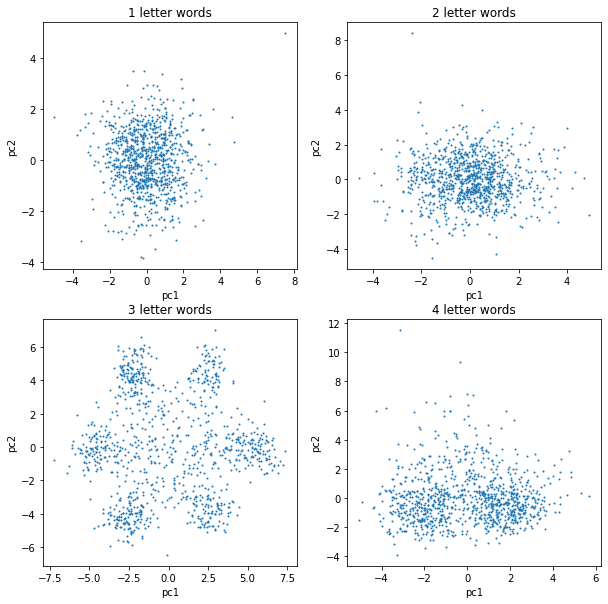

In [22]:
pca = PCA(n_components = 2)

pCompTables = {}

for i in range(1,5):
    pca.fit(normFreqTables[i])
    pComponents = pca.transform(normFreqTables[i])
    # for each word size, we store the result of the PCA in a table containing only the 2 princicipal components
    pCompTables[i] = pd.DataFrame(pComponents[:, [0,1]], columns = ['pc1', 'pc2'])
  
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i in range(1,5):
    plt.subplot(2,2,i)
    x = pCompTables[i].loc[:,'pc1']
    y = pCompTables[i].loc[:,'pc2']
    plt.scatter(x,y, s = 1)
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    plt.title(str(i) + ' letter words')

plt.show()

    


Each blue dot represents individual 300-character segment. From the plots we can clearly see that 3 letters generates identifiable visual relations between data points. These 3 letter words are called codons in biology.

# Clustering

We will now cluster the 3 letter word gene breakdown using the K-means Clustering unsupervised algorithm. From the previous section, we can detect 6 or 7 clusters.<br>
Knowing that some genes do not carry information, we are led to think that the center points, far from the 6 distinct centroids, could be a candidate for those. We therefore assume that there are 7 clusters. 

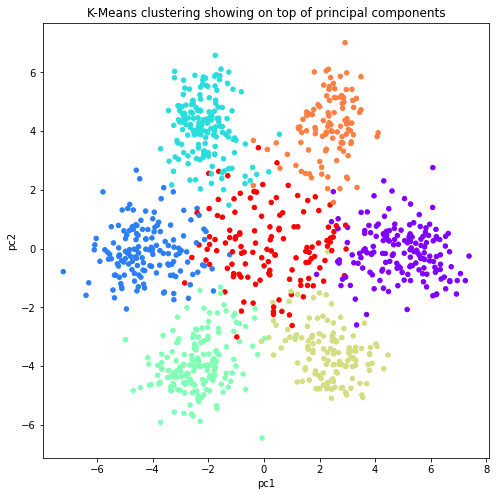

In [23]:
kmeans = KMeans(n_clusters = 7)
kmeans.fit(normFreqTables[3])

plt.figure(figsize=(8,8))

x = pCompTables[3].loc[:,'pc1']
y = pCompTables[3].loc[:,'pc2']
plt.scatter(x,y, s = 20, c=kmeans.labels_, cmap = 'rainbow')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title('K-Means clustering showing on top of principal components')

plt.show()

Hence, Unsupervised Learning through Clustering (K-means Clustering) and Dimensionality Reduction (PCA) has allowed us to visualize, validate and provide supporting evidence for the biological discovery that the DNA genetic sequence is organized into 3-letter words called codons, which are actually responsible for the amino acids and proteins that are produced by living cells.